## 1. Download dan Unzip Dataset

In [1]:
!gdown --id 1kqjGOrEzePq7gq-27tO5dcR8L_j4IKG4

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kqjGOrEzePq7gq-27tO5dcR8L_j4IKG4
To: /content/Vehicle.rar
100% 20.2M/20.2M [00:00<00:00, 58.4MB/s]


In [2]:
!pip install rarfile

In [3]:
import rarfile
import os

with rarfile.RarFile('Vehicle.rar', 'r') as rf:
    rf.extractall()

In [4]:
# menentukan path dari dataset untuk training dan dataset untuk validasi
train_dir = '/content/Vehicle/train'
validation_dir = '/content/Vehicle/validation'

train_data_nonvehicles = os.listdir(train_dir + '/non-vehicles/')
train_data_vehicles = os.listdir(train_dir + '/vehicles/')

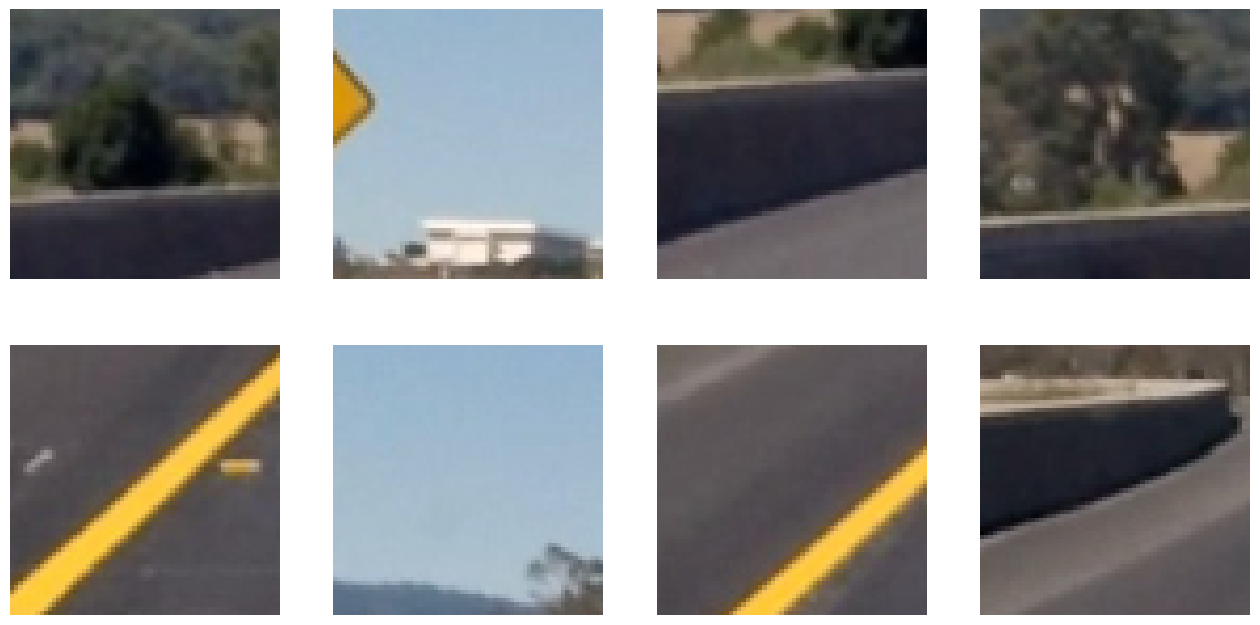

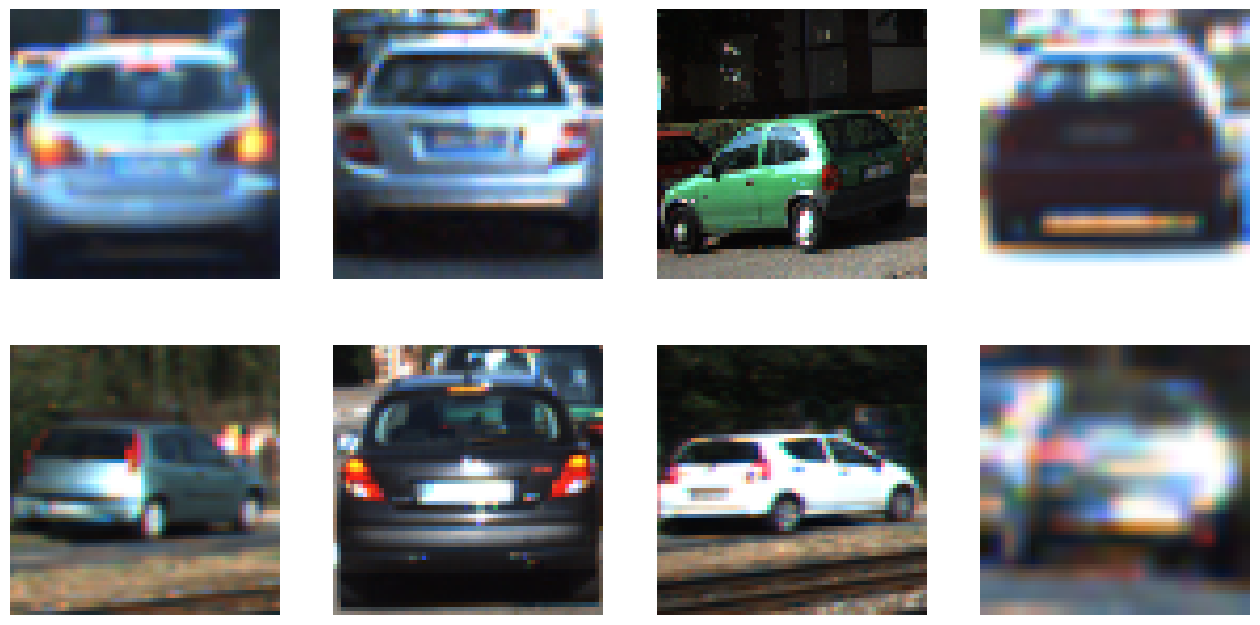

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

next_cats_pic = train_data_nonvehicles[:8]
next_dogs_pic = train_data_vehicles[:8]

for i, img_path in enumerate(next_cats_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(train_dir + '/non-vehicles/' + img_path)
  plt.imshow(img)
plt.show()

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

for i, img_path in enumerate(next_dogs_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(train_dir + '/vehicles/' + img_path)
  plt.imshow(img)
plt.show()

# 2. Preprocessing Data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# melakukan image augmentation pada dataset untuk menambah variasi data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)
                                   #dtype=tf.float32

test_datagen = ImageDataGenerator( rescale = 1.0/255.,)
                                   #dtype=tf.float32)

# melakukan data generator untuk membaca dataset training di setiap label
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = (224, 224))

# # melakukan data generator untuk membaca dataset testing di setiap label
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'binary',
                                                          target_size = (224, 224))

Found 1949 images belonging to 2 classes.
Found 836 images belonging to 2 classes.


## 3. Modeling

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

In [8]:
#@title Pilih Pretrained Model :  { display-mode: "both" }
Model = "MobileNet" #@param ["VGG16", "MobileNet", "InceptionNet", "ResNet"]

# Pilihan pretrained model yang dapat digunakan di sesi ini
if Model == "VGG16":
  base_model = VGG16(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

elif Model == "ResNet50":
  base_model = ResNet50(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

elif Model == "MobileNet":
  base_model = MobileNet(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

else:
  base_model = InceptionV3(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

print("Anda akan menggunakan model : ", Model)

# membuat base model tidak diikutkan proses training
for layer in base_model.layers:
  layer.trainable = False

17225924/17225924 [==============================] - 1s 0us/step
Anda akan menggunakan model :  MobileNet


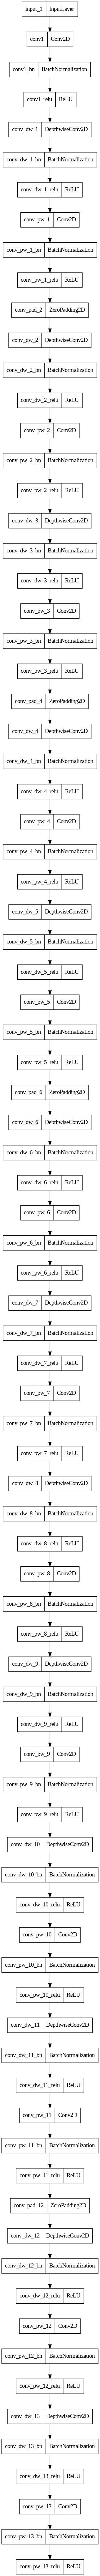

In [9]:
# membuat visualisasi plot arsetektur yang telah kita pilih
plot_model(base_model, to_file='my_base_model.png')

In [10]:
# kita juga bisa menggunakan .summary() untuk menampilkan arsitektur kita
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [11]:
import tensorflow as tf


x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.15)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(train_generator, validation_data=validation_generator,
                    steps_per_epoch = 60, epochs = 10)

Epoch 1/10
60/60 [==============================] - 47s 466ms/step - loss: 0.0889 - accuracy: 0.9708 - val_loss: 0.0429 - val_accuracy: 0.9809
Epoch 2/10
60/60 [==============================] - 25s 411ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 3/10
60/60 [==============================] - 30s 495ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 0.0064 - val_accuracy: 0.9988
Epoch 4/10
60/60 [==============================] - 26s 435ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0035 - val_accuracy: 0.9988
Epoch 5/10
60/60 [==============================] - 26s 442ms/step - loss: 6.3515e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9988
Epoch 6/10
60/60 [==============================] - 27s 456ms/step - loss: 4.1245e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/10
60/60 [==============================] - 27s 439ms/step - loss: 2.7740e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accu

# 4. Evaluasi

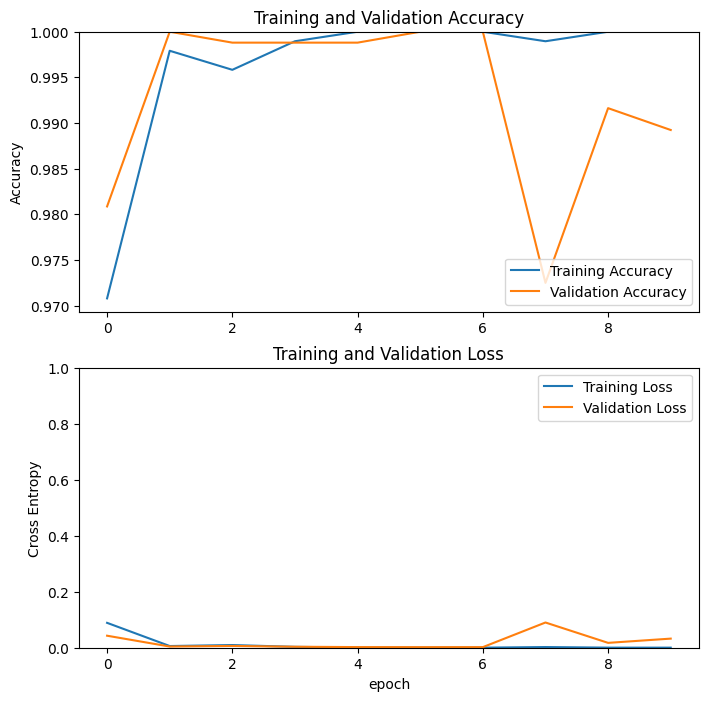

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

27/27 [==============================] - 2s 44ms/step


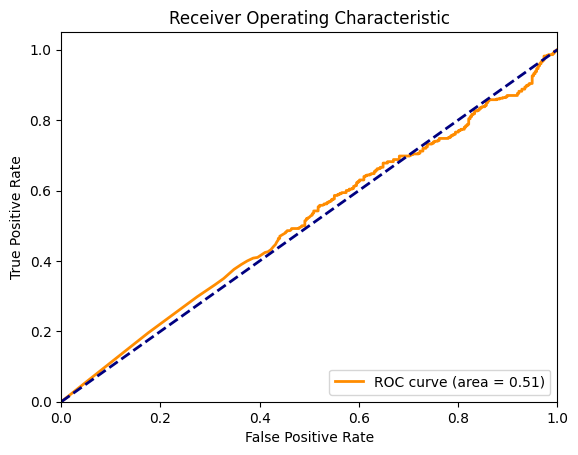

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

preds = model.predict(validation_generator, verbose=1)
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 5. Testing Pada Images

Saving 17.png to 17.png


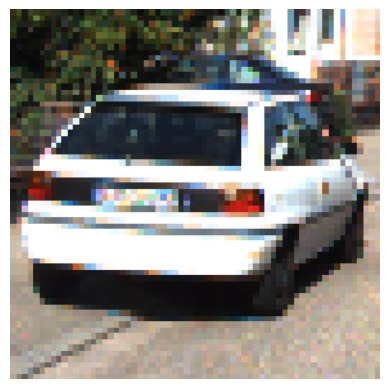

1/1 [==============================] - 1s 1s/step

 ini kendaraan


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)

  plt.imshow(x/255.)
  plt.axis('off')
  plt.show()

  x = np.expand_dims(x, axis=0)
  # images = np.vstack([x])

  classes = model.predict(x)

  if classes[0]<0.5:
    print("\n ini bukan kendaraan")
  else:
    print("\n ini kendaraan")